In [52]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
import xgboost as xgb
from sklearn.metrics import accuracy_score, precision_score, confusion_matrix
import missingno as msno
%matplotlib inline
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import KFold
from sklearn.metrics import accuracy_score
from sklearn.svm import SVC

# removing scientific notation
pd.set_option('display.float_format', lambda x: '%.3f' % x)

In [13]:
# importing the dataset
df=pd.read_csv('GDM Dataset.csv')

# sanity check
df.sample(5)

,AgeAtStartOfSpell,WeightMeasured,Height,Body Mass Index at Booking,Obese?,Ethnicity,Risk Factors,AntenatalMedicalFactors,Parity,Gravida,Glucoselevelblood,GlucoseToleranceTest,Glucoselevel0minblood,Glucoselevel120minblood,Gestational Diabetes
11038,30,77.798,160.000,30.390,Yes,AFE,None,None,1,2.000,NaN,Offered and accepted,4.9,6.5,No
21536,39,48.010,163.000,18.070,No,OTH,None,None,1,3.000,4.4,Offered and accepted,4.1,7.8,Yes
18529,37,65.394,165.000,24.020,No,WEU,None,Diabetes/endocrine disorder,0,2.000,NaN,Offered and accepted,5.1,7.8,Yes
14819,34,49.014,170.000,16.960,No,MEA,"Recent migrant (last 12 months), Underweight-B...",None,0,1.000,NaN,Offered and accepted,NaN,NaN,No
17150,34,67.596,168.000,23.950,No,NAF,None,None,3,6.000,NaN,Offered and accepted,4.3,5.2,No


In [14]:
# checking the shape of the dataset
shape = df.shape
print(f"The shape of the dataframe is {shape[0]} rows and {shape[1]} columns")

The shape of the dataframe is 23490 rows and 15 columns


In [15]:
# checking the data types of the columns
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 23490 entries, 0 to 23489
Data columns (total 15 columns):
 #   Column                      Non-Null Count  Dtype  
---  ------                      --------------  -----  
 0   AgeAtStartOfSpell           23490 non-null  int64  
 1   WeightMeasured              23490 non-null  float64
 2   Height                      23490 non-null  float64
 3   Body Mass Index at Booking  23490 non-null  float64
 4   Obese?                      23490 non-null  object 
 5   Ethnicity                   23490 non-null  object 
 6   Risk Factors                23476 non-null  object 
 7   AntenatalMedicalFactors     23472 non-null  object 
 8   Parity                      23490 non-null  int64  
 9   Gravida                     23479 non-null  float64
 10  Glucoselevelblood           2648 non-null   object 
 11  GlucoseToleranceTest        15213 non-null  object 
 12  Glucoselevel0minblood       16938 non-null  object 
 13  Glucoselevel120minblood     169

In [16]:
# checking for duplicate rows
duplucate_rows = df.duplicated().sum()
print(f"The number of duplicate rows are {duplucate_rows}.")

The number of duplicate rows are 43.


In [17]:
# sanity check
df.shape

(23490, 15)

In [18]:
# checking for the total amount of null values
df.isnull().sum()

AgeAtStartOfSpell                 0
WeightMeasured                    0
Height                            0
Body Mass Index at Booking        0
Obese?                            0
Ethnicity                         0
Risk Factors                     14
AntenatalMedicalFactors          18
Parity                            0
Gravida                          11
Glucoselevelblood             20842
GlucoseToleranceTest           8277
Glucoselevel0minblood          6552
Glucoselevel120minblood        6572
Gestational Diabetes              0
dtype: int64

In [19]:
# checking for the total amount of null values as a percentage.
df.isna().sum()/df.shape[0]*100

AgeAtStartOfSpell             0.000
WeightMeasured                0.000
Height                        0.000
Body Mass Index at Booking    0.000
Obese?                        0.000
Ethnicity                     0.000
Risk Factors                  0.060
AntenatalMedicalFactors       0.077
Parity                        0.000
Gravida                       0.047
Glucoselevelblood            88.727
GlucoseToleranceTest         35.236
Glucoselevel0minblood        27.893
Glucoselevel120minblood      27.978
Gestational Diabetes          0.000
dtype: float64

In [20]:
# Delete columns containing more than 50% null values
percentage = 65
min_count =  int(((100-percentage)/100)*df.shape[0] + 1)
df = df.dropna(axis=1, thresh=min_count)

print(f"The columns with {percentage}% or more null values are: {df.columns[df.isna().sum()/df.shape[0]*100 > percentage]}")
print(f"The new shape of the dataframe is {df.shape[0]} rows and {df.shape[1]} columns.")

The columns with 65% or more null values are: Index([], dtype='object')
The new shape of the dataframe is 23490 rows and 14 columns.


In [21]:
# checking how many null values are in the dataframe that are over 0%
percentage = df.isna().sum()/df.shape[0]*100
pd.DataFrame(percentage[percentage > 0])

,0
Risk Factors,0.060
AntenatalMedicalFactors,0.077
Gravida,0.047
GlucoseToleranceTest,35.236
Glucoselevel0minblood,27.893
Glucoselevel120minblood,27.978


In [22]:
# creating a copy of the dataframe
df2 = df.copy()

In [23]:
# Identify categorical values in 'Glucoselevel0minblood' and replace with NaN
is_categorical = df2['Glucoselevel0minblood'].str.contains(r'[A-Za-z]').any()
if is_categorical:
    df2['Glucoselevel0minblood'] = df2['Glucoselevel0minblood'].replace(r'[A-Za-z]', np.nan, regex=True)


In [24]:
# Identify categorical values in 'Glucoselevel120minblood' and replace with NaN
is_categorical = df2['Glucoselevel120minblood'].str.contains(r'[A-Za-z]').any()
if is_categorical:
    df2['Glucoselevel120minblood'] = df2['Glucoselevel120minblood'].replace(r'[A-Za-z]', np.nan, regex=True)

In [25]:
#Replaces the null values with most prominent data in the feature
def replace_nan_with_most_frequent(df):
    # Iterate over each column in the dataframe
    for column in df.columns:
        # Check if NaN values exist in the column
        if df[column].isnull().any():
            # Calculate the most frequent value in the column
            most_frequent_value = df[column].mode().values[0]
            # Replace NaN values with the most frequent value
            df[column].fillna(most_frequent_value, inplace=True)

replace_nan_with_most_frequent(df2)


In [26]:
#Converting Glucose level to float datatype
df2['Glucoselevel0minblood'] = df2['Glucoselevel0minblood'].astype(float)
df2['Glucoselevel120minblood'] = df2['Glucoselevel120minblood'].astype(float)

In [27]:
#converting the Target Feature to Numerical Values
mapping = {'Yes': 1, 'No': 0}
df2['Gestational Diabetes'] = df2['Gestational Diabetes'].map(mapping)

In [28]:
#converting the Obesity to Numerical Values
mapping = {'Yes': 1, 'No': 0}
df2['Obese?'] = df2['Obese?'].map(mapping)

In [29]:
# checking how many numerical columns are in the dataframe
df2.select_dtypes(exclude='object').nunique()

AgeAtStartOfSpell                40
WeightMeasured                11026
Height                          259
Body Mass Index at Booking     2501
Obese?                            2
Parity                           12
Gravida                          20
Glucoselevel0minblood            70
Glucoselevel120minblood         138
Gestational Diabetes              2
dtype: int64

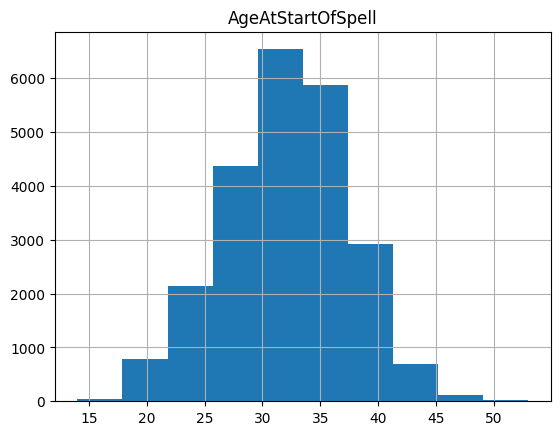

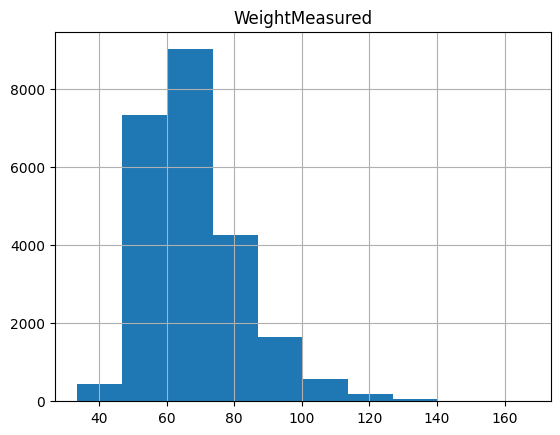

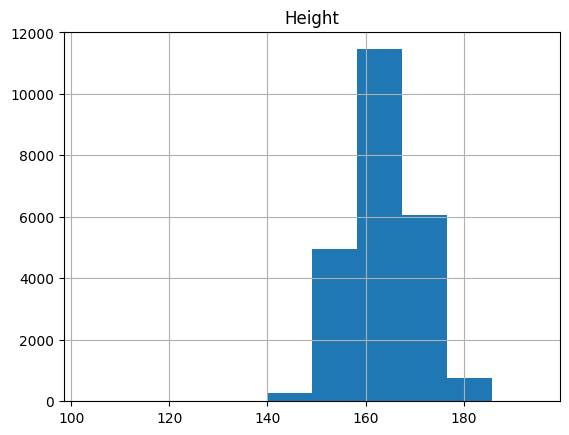

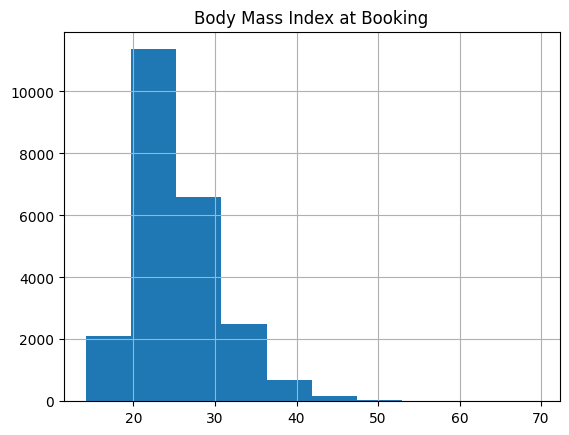

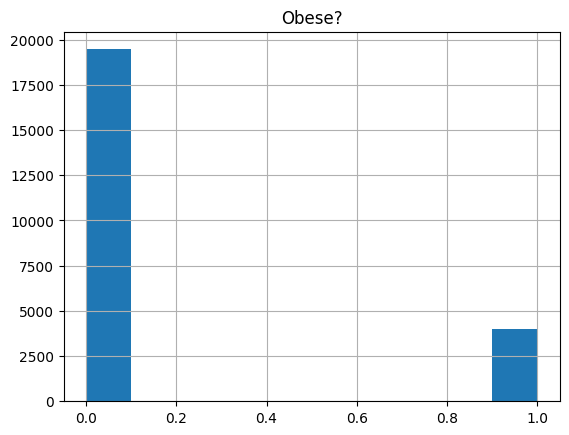

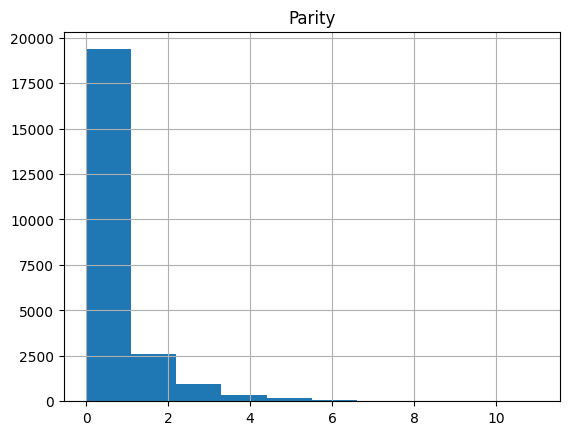

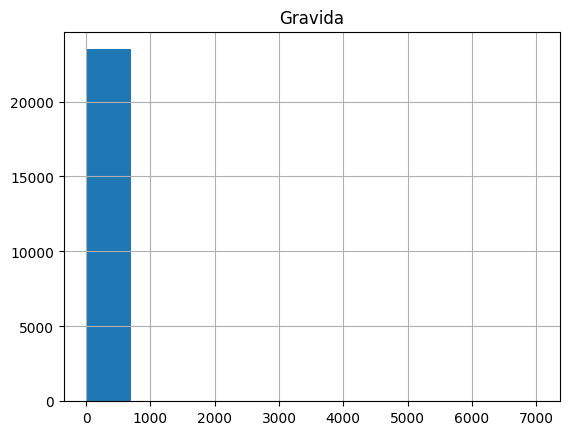

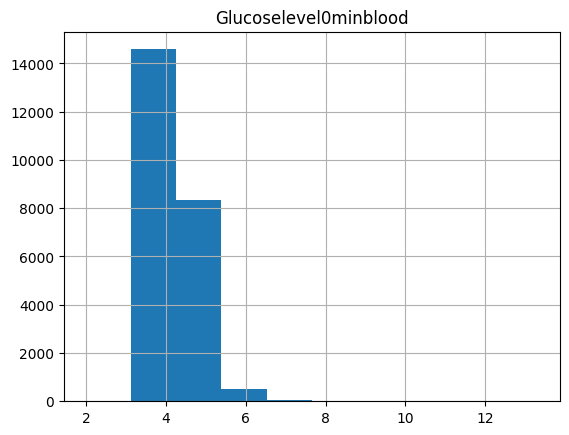

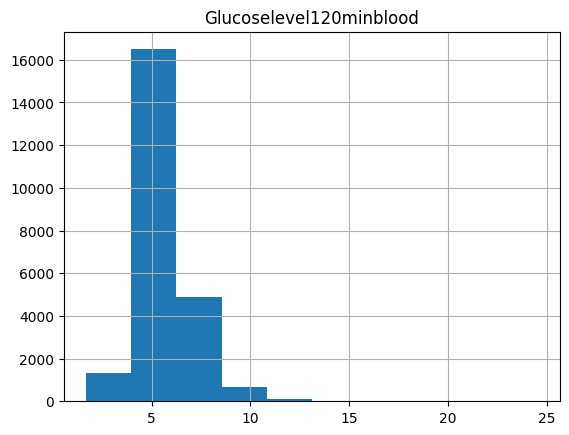

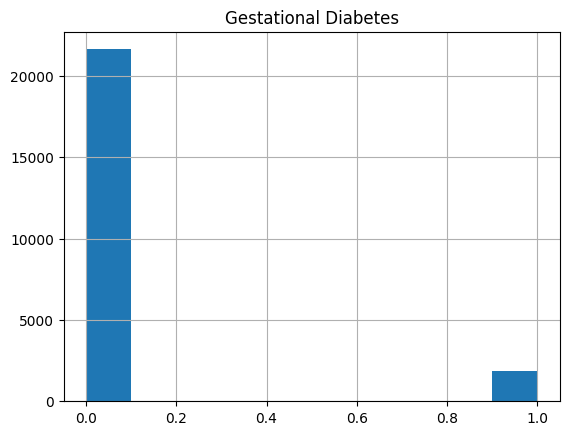

In [30]:
# Pull out the categorical variables
numerical_df = df2.select_dtypes(['float', 'int64'])

# Iterate column by column
for column in numerical_df:

    # Do Something
    numerical_df[column].hist()
    plt.title(column)
    plt.show()

                            Gestational Diabetes
AgeAtStartOfSpell                          0.104
WeightMeasured                             0.046
Height                                    -0.112
Body Mass Index at Booking                 0.095
Obese?                                     0.069
Parity                                     0.037
Gravida                                   -0.001
Glucoselevel0minblood                      0.381
Glucoselevel120minblood                    0.638
Gestational Diabetes                       1.000


<ipython-input-31-c984577c0a9e>:5: FutureWarning: The default value of numeric_only in DataFrame.corr is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.
  corr_matrix = df2.corr()[[target_feature]]


<Axes: >

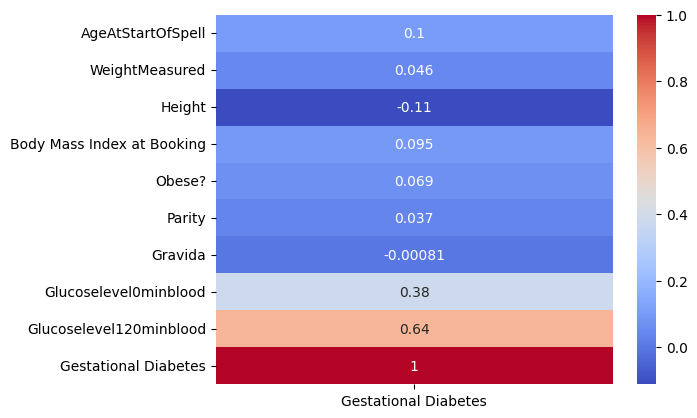

In [31]:
# Specify the target feature name
target_feature = 'Gestational Diabetes'

# Compute the correlation matrix with respect to the target feature
corr_matrix = df2.corr()[[target_feature]]

# Print the correlation matrix
print(corr_matrix)

# Plot the correlation matrix as a heatmap
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm')


<ipython-input-32-a074c3c90aee>:2: FutureWarning: The default value of numeric_only in DataFrame.corr is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.
  corr_df = df2.corr()


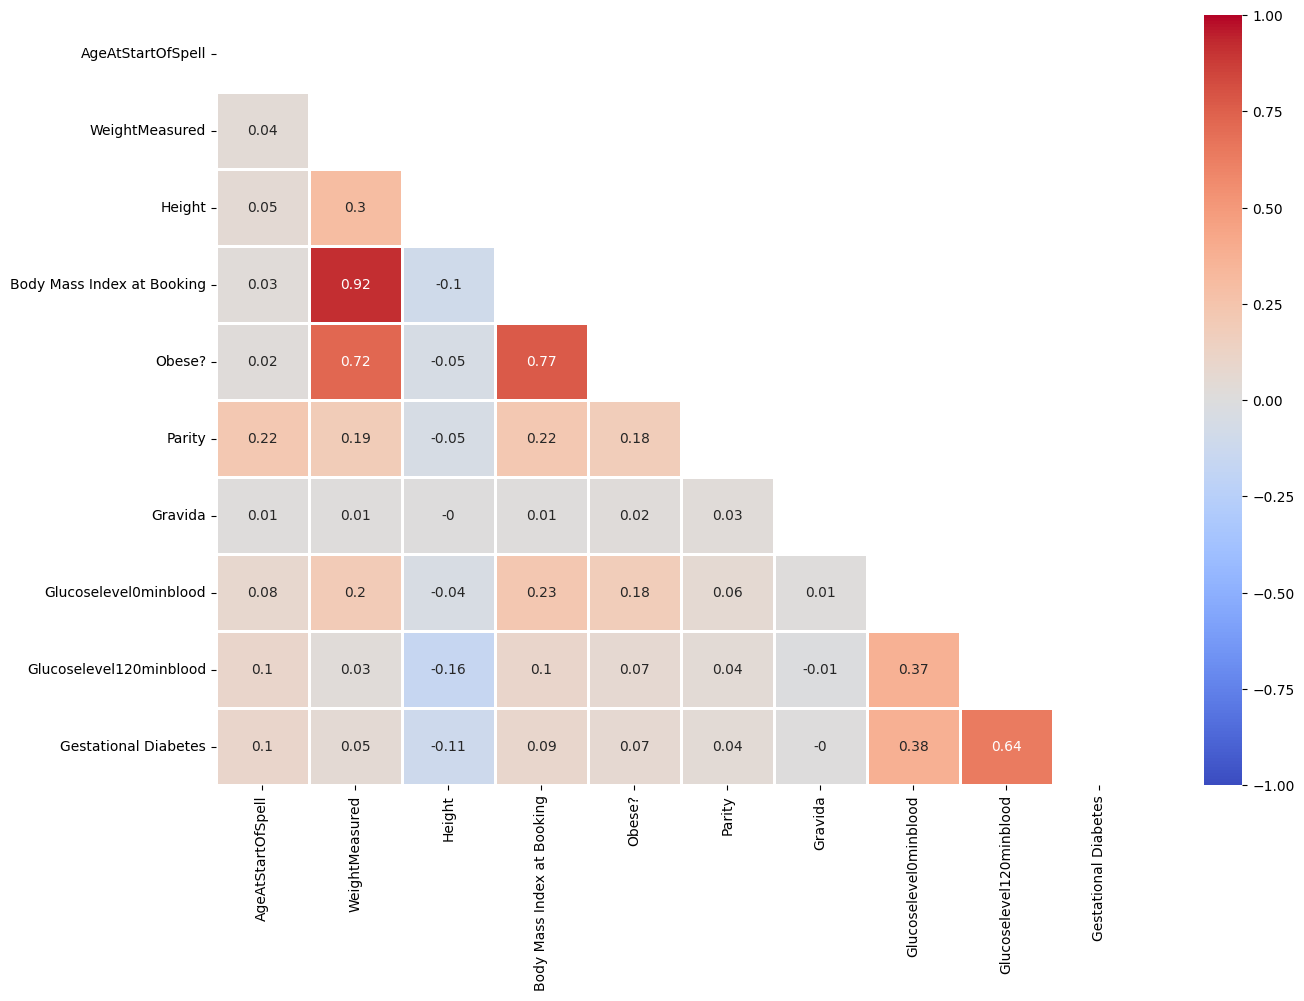

In [32]:
# instantiating the correlation matrix
corr_df = df2.corr()

# Create a mask to only show the lower triangle of the correlation matrix
mask = np.triu(corr_df)

# Set up the matplotlib figure
plt.figure(figsize=(15, 10))
sns.heatmap(corr_df.round(2), annot=True, vmax=1, vmin=-1,
            center=0, cmap="coolwarm", mask=mask, linewidths=1)
plt.show()

In [33]:
cat_col = df2.select_dtypes(include='object').columns
cat_col

Index(['Ethnicity', 'Risk Factors', 'AntenatalMedicalFactors',
       'GlucoseToleranceTest'],
      dtype='object')

In [34]:
# looping through the categorical columns and using get_dummies to create dummy variables
for col in cat_col:
    dummies = pd.get_dummies(df2[col], prefix=col, drop_first=True)
    df2 = pd.concat([df2, dummies], axis=1)
    df2.drop(col, axis=1, inplace=True)

# checking the result
df2.head()

,AgeAtStartOfSpell,WeightMeasured,Height,Body Mass Index at Booking,Obese?,Parity,Gravida,Glucoselevel0minblood,Glucoselevel120minblood,Gestational Diabetes,...,AntenatalMedicalFactors_Serious gastroenterological conditions,AntenatalMedicalFactors_Serious neurological conditions,"AntenatalMedicalFactors_Serious neurological conditions, None",AntenatalMedicalFactors_Thromboembolic disease,"AntenatalMedicalFactors_Thromboembolic disease, None","AntenatalMedicalFactors_Thromboembolic disease, Venous Thromboembolism",AntenatalMedicalFactors_Venous Thromboembolism,"AntenatalMedicalFactors_Venous Thromboembolism, None",GlucoseToleranceTest_Offered and accepted,GlucoseToleranceTest_Offered and declined
0,30,101.009,178.000,31.880,1,0,1.000,4.600,5.500,0,...,0,0,0,0,0,0,0,0,1,0
1,29,91.014,173.000,30.410,1,0,1.000,4.300,7.000,0,...,0,0,0,0,0,0,0,0,1,0
2,22,65.395,168.000,23.170,0,0,1.000,4.200,5.600,0,...,0,0,0,0,0,0,0,0,0,1
3,31,49.997,170.000,17.300,0,0,1.000,4.200,5.600,0,...,0,0,0,0,0,0,0,0,0,0
4,24,54.301,171.000,18.570,0,0,1.000,4.200,5.600,0,...,0,0,0,0,0,0,0,0,0,0


In [35]:
# checking the correlation between the Gestational Diabetes and the other variables
matrix = pd.DataFrame(df2.corr()['Gestational Diabetes'].sort_values(ascending=False)).style.background_gradient(cmap='coolwarm')
matrix

,Gestational Diabetes
Gestational Diabetes,1.000000
Glucoselevel120minblood,0.638139
Glucoselevel0minblood,0.380595
AgeAtStartOfSpell,0.103844
Body Mass Index at Booking,0.094612
Ethnicity_OTH,0.080990
Obese?,0.068892
Ethnicity_IND,0.065621
GlucoseToleranceTest_Offered and accepted,0.051228
WeightMeasured,0.046073


In [36]:
# checking the result
df2.shape

(23490, 429)

In [37]:
# making a list of the columns that have a correlation between 0.05 and -0.05 with the Gestational Diabetes column
columns_to_drop = []

for col in df2.columns:
    if df2[col].corr(df2['Gestational Diabetes']) < 0.05 and df2[col].corr(df2['Gestational Diabetes']) > -0.05:
       columns_to_drop.append(col)

# checking the list
columns_to_drop

['WeightMeasured',
 'Parity',
 'Gravida',
 'Ethnicity_ASE',
 'Ethnicity_BGD',
 'Ethnicity_CAE',
 'Ethnicity_CAR',
 'Ethnicity_IRL',
 'Ethnicity_MEA',
 'Ethnicity_NAF',
 'Ethnicity_PAK',
 'Ethnicity_WEU',
 "Risk Factors_Age < 20, Can't speak or understand English",
 "Risk Factors_Age < 20, Can't speak or understand English, Complex social factors, Refugee or asylum seeker",
 "Risk Factors_Age < 20, Can't speak or understand English, Homeless, Recent migrant (last 12 months), Refugee or asylum seeker",
 "Risk Factors_Age < 20, Can't speak or understand English, Obesity-BMI>=35, Refugee or asylum seeker",
 "Risk Factors_Age < 20, Can't speak or understand English, Recent migrant (last 12 months)",
 "Risk Factors_Age < 20, Can't speak or understand English, Recent migrant (last 12 months), Refugee or asylum seeker",
 "Risk Factors_Age < 20, Can't speak or understand English, Refugee or asylum seeker",
 "Risk Factors_Age < 20, Can't speak or understand English, Refugee or asylum seeker, Saf

In [38]:
# dropping the columns
df2.drop(columns_to_drop, axis=1, inplace=True)

# checking the result
df2.shape

(23490, 11)

In [39]:
# checking the correlation between the Gestational Diabetes and the other variables
pd.DataFrame(df2.corr()['Gestational Diabetes'].sort_values(ascending=False)).style.background_gradient(cmap='coolwarm')

,Gestational Diabetes
Gestational Diabetes,1.000000
Glucoselevel120minblood,0.638139
Glucoselevel0minblood,0.380595
AgeAtStartOfSpell,0.103844
Body Mass Index at Booking,0.094612
Ethnicity_OTH,0.080990
Obese?,0.068892
Ethnicity_IND,0.065621
GlucoseToleranceTest_Offered and accepted,0.051228
Ethnicity_GBR,-0.067899


In [40]:
df2.sample(5)

,AgeAtStartOfSpell,Height,Body Mass Index at Booking,Obese?,Glucoselevel0minblood,Glucoselevel120minblood,Gestational Diabetes,Ethnicity_GBR,Ethnicity_IND,Ethnicity_OTH,GlucoseToleranceTest_Offered and accepted
14189,25,154.000,21.460,0,3.900,6.000,0,0,0,0,1
1597,42,182.500,20.360,0,4.200,7.600,0,1,0,0,1
15498,28,163.000,27.170,0,4.700,7.200,0,0,0,1,1
3107,40,169.000,25.310,0,4.300,6.200,0,0,0,0,1
16238,33,154.000,19.900,0,4.200,5.600,0,1,0,0,1


In [41]:
#Renaming the features
new_names = {'AgeAtStartOfSpell': 'Age', 'Body Mass Index at Booking': 'Body Mass Index (BMI)', 'Glucoselevel0minblood': 'OGTT1h', 'Glucoselevel120minblood': 'OGTT2h', 'Obese?': 'Obesity', 'GlucoseToleranceTest_Offered and accepted': 'Gravida (Is this your first Pregnancy?)'}
df2.rename(columns=new_names, inplace=True)

In [42]:
df2.sample(5)

,Age,Height,Body Mass Index (BMI),Obesity,OGTT1h,OGTT2h,Gestational Diabetes,Ethnicity_GBR,Ethnicity_IND,Ethnicity_OTH,Gravida (Is this your first Pregnancy?)
19877,41,165.000,24.240,0,4.200,5.500,0,0,0,0,1
6329,43,160.000,26.950,0,5.300,9.100,1,0,0,0,1
13415,34,163.000,19.870,0,4.200,5.600,0,0,0,0,0
980,34,167.000,22.590,0,5.000,4.900,0,1,0,0,1
19490,33,162.000,33.190,1,5.100,6.300,0,0,0,1,1


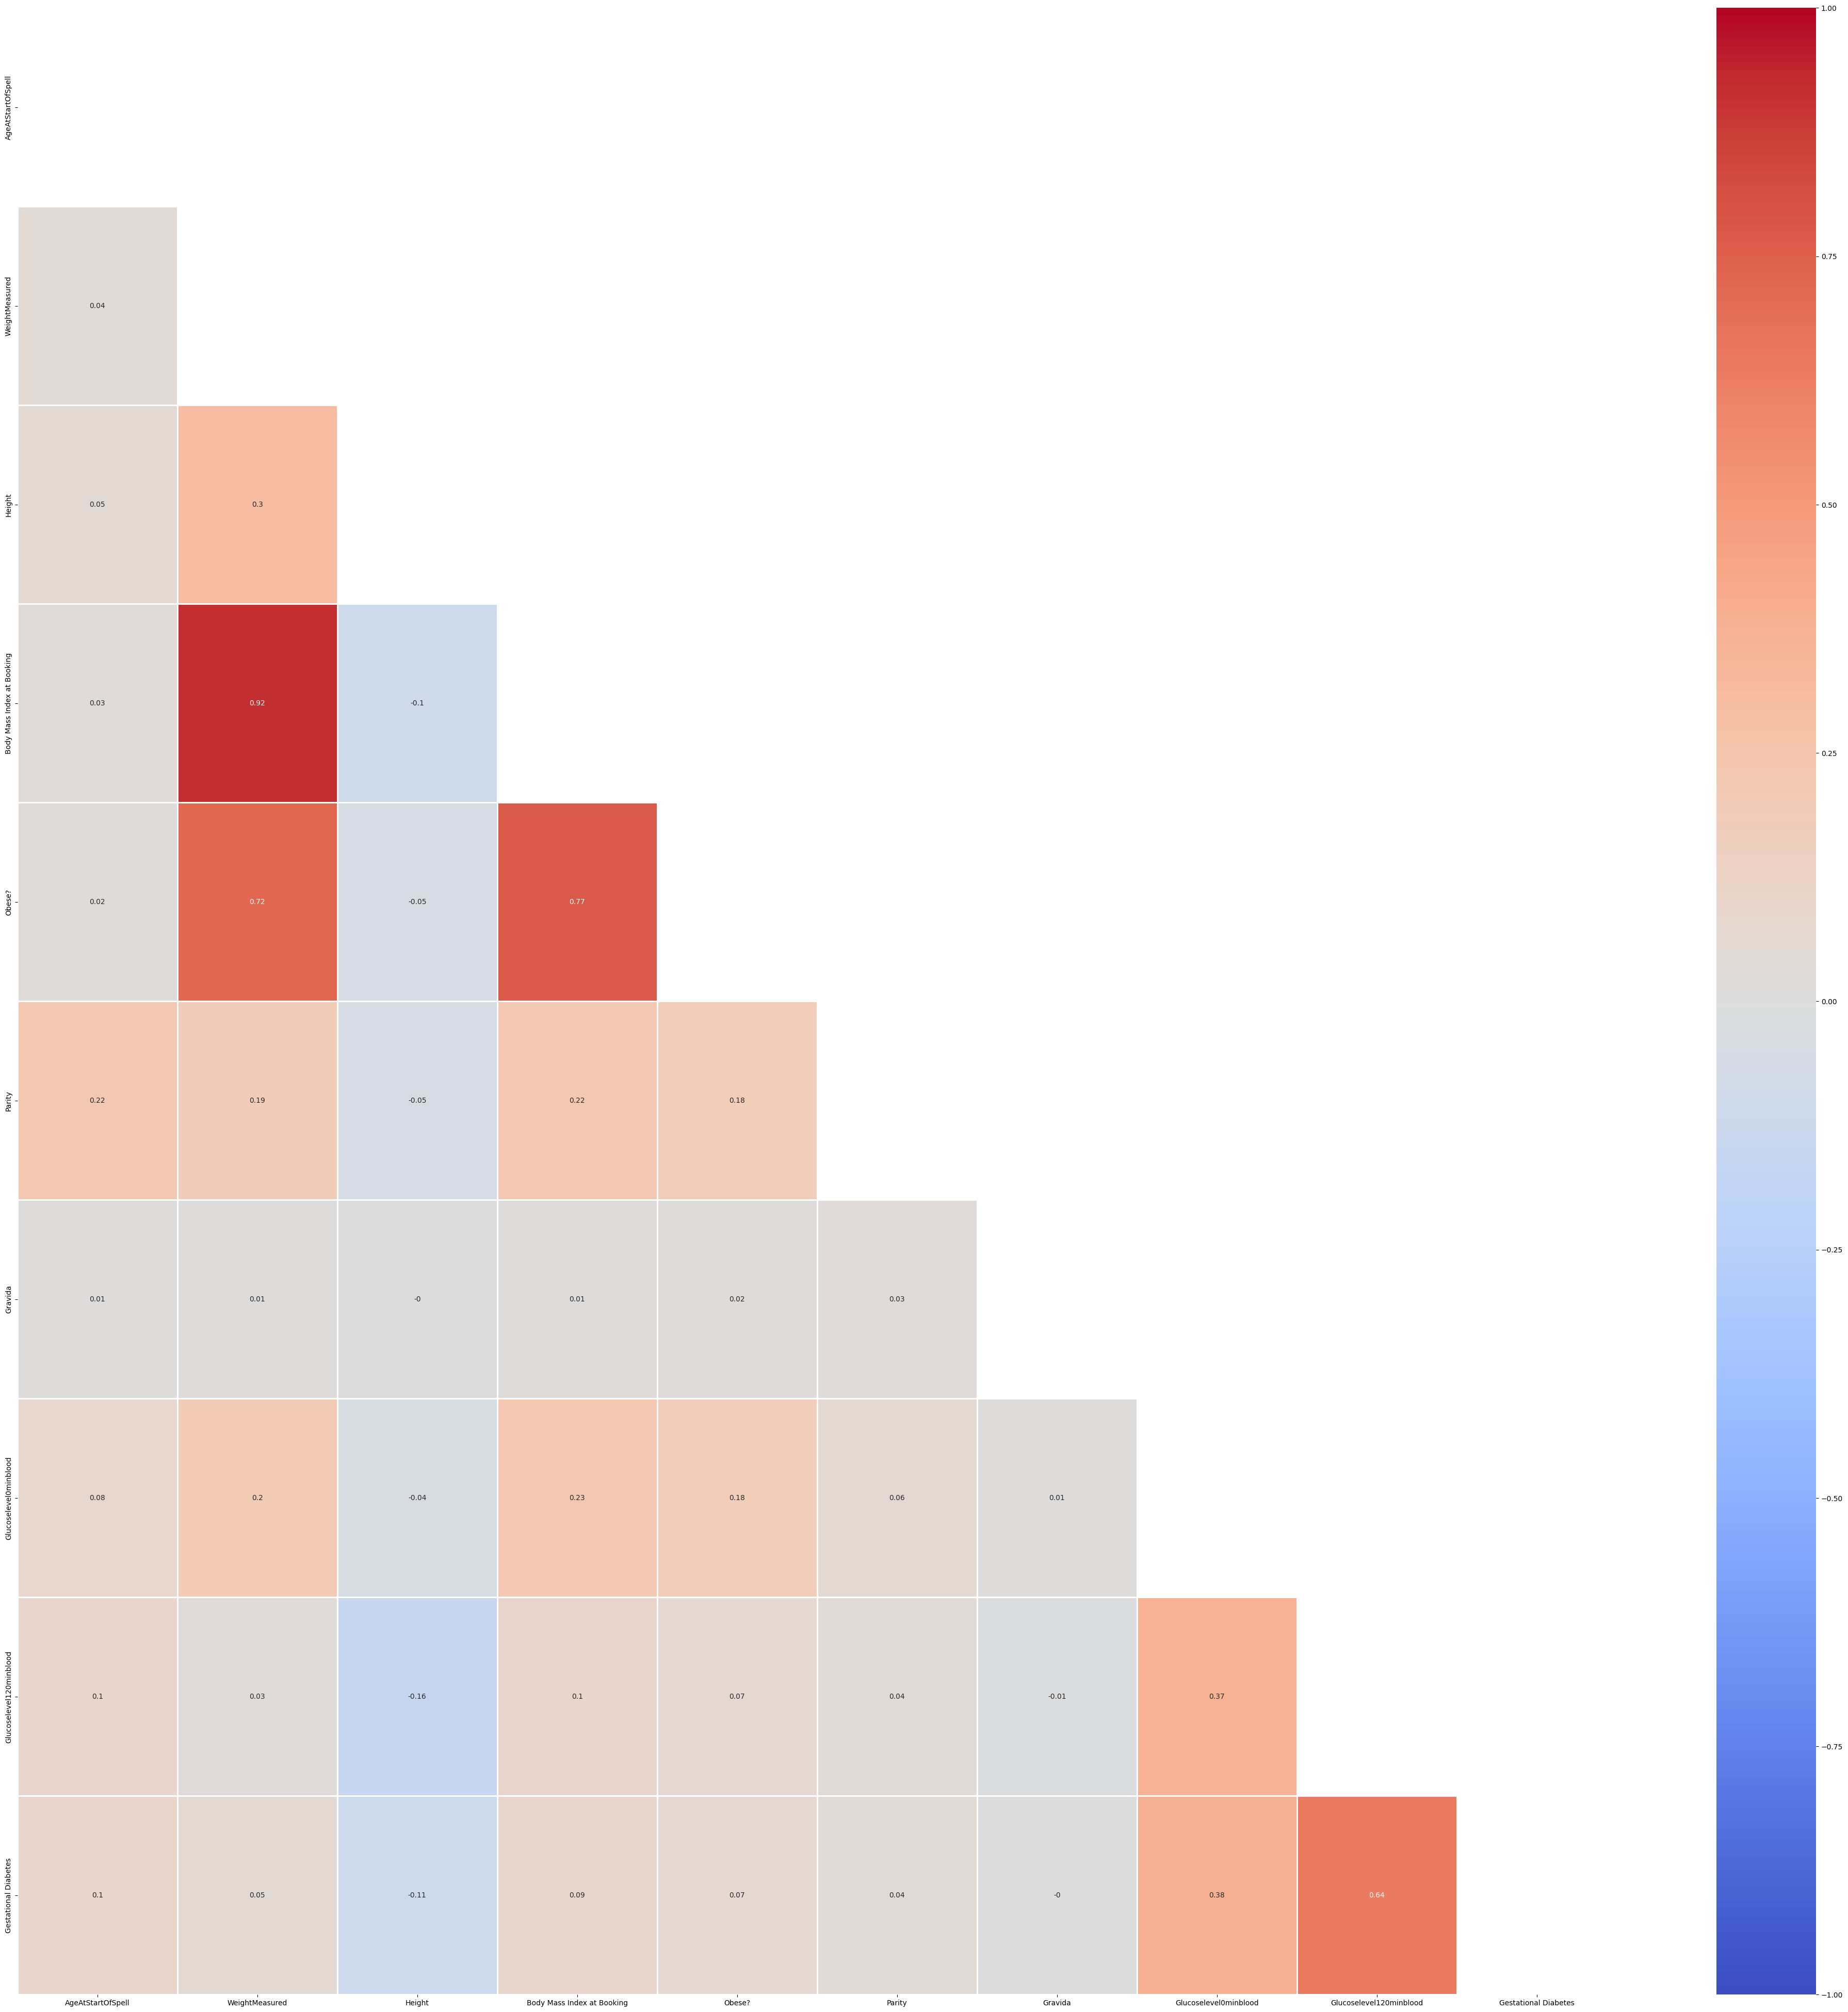

In [43]:
# instantiating the correlation matrix
df = df2.corr()

# Create a mask to only show the lower triangle of the correlation matrix
mask = np.triu(corr_df)

# Set up the matplotlib figure
plt.figure(figsize=(50, 50))
sns.heatmap(corr_df.round(2), annot=True, vmax=1, vmin=-1,
            center=0, cmap="coolwarm", mask=mask, linewidths=1)
plt.show()

In [79]:
df2.sample(5)

,Age,Height,Body Mass Index (BMI),Obesity,OGTT1h,OGTT2h,Gestational Diabetes,Ethnicity_GBR,Ethnicity_IND,Ethnicity_OTH,Gravida (Is this your first Pregnancy?)
18265,36,165.000,20.940,0,4.200,5.600,0,1,0,0,0
3619,38,166.000,26.130,0,3.900,5.300,0,0,0,0,1
18699,37,170.000,25.120,0,3.700,4.500,0,0,0,0,1
6437,33,167.000,23.380,0,4.200,5.600,0,0,0,0,0
5791,31,175.000,25.800,0,4.200,5.600,0,0,0,0,1


In [80]:
# Exporting the dataframe to a csv file
df2.to_csv("GDM_cleaned.csv")

In [76]:
# # removing scientific notation
# pd.set_option('display.float_format', lambda x: '%.3f' % x)

In [81]:
# Importing the data
df = pd.read_csv("GDM_cleaned.csv")

In [82]:
df.sample(5)

,Unnamed: 0,Age,Height,Body Mass Index (BMI),Obesity,OGTT1h,OGTT2h,Gestational Diabetes,Ethnicity_GBR,Ethnicity_IND,Ethnicity_OTH,Gravida (Is this your first Pregnancy?)
2686,2686,30,162.000,20.880,0,5.000,6.300,0,0,0,1,1
2839,2839,30,163.000,23.940,0,4.200,5.600,0,0,0,0,0
6607,6607,24,163.000,19.760,0,4.200,5.100,0,0,0,1,1
13766,13766,37,165.000,23.650,0,4.900,4.400,0,1,0,0,1
4955,4955,32,165.000,23.140,0,4.400,6.400,0,0,0,1,1


In [95]:
df = df.drop('Unnamed: 0', axis = 1)

KeyError: ignored

In [96]:
df.shape

(23490, 11)

In [100]:
df.sample(5)

,Age,Height,Body Mass Index (BMI),Obesity,OGTT1h,OGTT2h,Gestational Diabetes,Ethnicity_GBR,Ethnicity_IND,Ethnicity_OTH,Gravida (Is this your first Pregnancy?)
9146,32,160.000,47.890,1,5.400,8.000,1,0,0,0,1
8067,34,175.000,25.600,0,4.200,5.600,0,1,0,0,0
13630,36,159.000,28.560,0,5.100,4.900,0,0,0,1,1
11816,38,159.000,23.300,0,4.200,5.000,0,1,0,0,1
2906,26,170.000,26.990,0,5.000,8.200,1,0,0,0,1


In [49]:
pip install catboost

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 98.6/98.6 MB 3.3 MB/s eta 0:00:00


In [50]:
from catboost import CatBoostClassifier

In [51]:
#Setting up traning and testing data
y = df['Gestational Diabetes']
X = df.drop('Gestational Diabetes', axis=1)

In [119]:
X = X.drop('Unnamed: 0', axis = 1)

In [109]:
# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [123]:
X_train = X_train.drop('Unnamed: 0', axis = 1)
X_test = X_test.drop('Unnamed: 0', axis = 1)

In [136]:
#Checking the accuracy of the Classifier using SVC model

# Set up the classifier
clf = SVC(kernel='linear')

# Set up the cross-validation
kfold = KFold(n_splits=5, shuffle=True, random_state=42)

# Perform cross-validation
scores = cross_val_score(clf, X_train, y_train, cv=kfold, scoring='accuracy')
clf.fit(X_train, y_train)

Cross-Validation Accuracy Scores: [0.98191008 0.98191008 0.98376796 0.98376796 0.98403406]
Mean Accuracy: 0.9830780297943088


In [137]:
# Print the accuracy scores for each fold
print("Cross-Validation Accuracy Scores:", scores)

# Print the mean accuracy across all folds
print("Mean Training Accuracy:", np.mean(scores))

Cross-Validation Accuracy Scores: [0.98191008 0.98191008 0.98376796 0.98376796 0.98403406]
Mean Training Accuracy: 0.9830780297943088


In [140]:
#Calculating Test Accuracy
clf_predictions = clf.predict(X_test)
clf_accuracy = accuracy_score(y_test, clf_predictions)
clf_precision = precision_score(y_test, clf_predictions)
print("SVC Test Accuracy: ",clf_accuracy)
print("SVC Test Precision: ",clf_precision)

SVC Test Accuracy:  0.9844614729672201
SVC Test Precision:  0.9401993355481728


In [141]:
# Define the new data (dummy data for demonstration)
new_data = pd.DataFrame({
    "Age": [30],
    "Height": [185],
    "Body Mass Index (BMI)": [32],
    "Obesity": [1],
    "OGTT1h": [9],
    "OGTT2h": [7.5],
    "Ethnicity_GBR": [0],
    "Ethnicity_IND": [1],
    "Ethnicity_OTH": [0],
    "Gravida (Is this your first Pregnancy?)": [1]
})

In [142]:
svc_prediction = clf.predict(new_data)

# Map the predicted values to their corresponding labels
prediction_mapping = {0: "Non-GDM", 1: "GDM"}
svc_pred = prediction_mapping[svc_prediction[0]]
print("SVC Prediction:", svc_pred)

SVC Prediction: GDM
